In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.sql.types import StructType,IntegerType,FloatType,BooleanType,StringType
from pyspark.sql.functions import rand
conf = SparkConf().setMaster("local[*]").setAppName("My App")
sc = SparkContext.getOrCreate(conf = conf)
sc._conf.set('spark.executor.memory','15g')\
    .set('spark.driver.memory','15g')\
        .set('spark.driver.maxResultsSize','0')
spark=SparkSession.builder\
    .appName('myApp')\
        .config("spark.driver.memory", "15g")\
            .getOrCreate()

In [2]:
def load_data(files,schema):
    df=spark.read.csv(files,header=True
                  ,schema=schema)
    return df

def load_record_linkage_data():
    schema = StructType() \
      .add("id_1",IntegerType(),True) \
      .add("id_2",IntegerType(),True) \
      .add("cmp_fname_c1",FloatType(),True) \
      .add("cmp_fname_c2",FloatType(),True) \
      .add("cmp_lname_c1",FloatType(),True) \
      .add("cmp_lname_c2",FloatType(),True) \
      .add("cmp_sex",IntegerType(),True) \
      .add("cmp_bd",IntegerType(),True) \
      .add("cmp_bm",IntegerType(),True) \
      .add("cmp_by",IntegerType(),True) \
      .add("cmp_plz",IntegerType(),True) \
      .add("is_match",BooleanType(),False)
    files=[f'./data/block_{id}.csv' for id in range(1,11)]
    return load_data(files,schema=schema)

In [3]:
df=load_record_linkage_data()

In [4]:
df.groupBy('cmp_plz').count().show()

+-------+-------+
|cmp_plz|  count|
+-------+-------+
|   null|  12843|
|      1|  31714|
|      0|5704575|
+-------+-------+



In [5]:
df.count()

5749132

In [6]:
df.printSchema()

root
 |-- id_1: integer (nullable = true)
 |-- id_2: integer (nullable = true)
 |-- cmp_fname_c1: float (nullable = true)
 |-- cmp_fname_c2: float (nullable = true)
 |-- cmp_lname_c1: float (nullable = true)
 |-- cmp_lname_c2: float (nullable = true)
 |-- cmp_sex: integer (nullable = true)
 |-- cmp_bd: integer (nullable = true)
 |-- cmp_bm: integer (nullable = true)
 |-- cmp_by: integer (nullable = true)
 |-- cmp_plz: integer (nullable = true)
 |-- is_match: boolean (nullable = true)



# Missing Values

### Drop Missing Values


In [7]:
miss_df=df.drop('id_1','id_2')

اگر همه داده های گم شده را حذف کنیم، کلا 20 رکورد باقی می‌ ماند !


In [8]:
miss_df.replace('?',None).na.drop().count()

20

In [9]:
miss_df=miss_df.replace('?',None)

In [10]:
miss_df.head(3)

[Row(cmp_fname_c1=0.8333333134651184, cmp_fname_c2=None, cmp_lname_c1=1.0, cmp_lname_c2=None, cmp_sex=1, cmp_bd=1, cmp_bm=1, cmp_by=1, cmp_plz=0, is_match=True),
 Row(cmp_fname_c1=1.0, cmp_fname_c2=None, cmp_lname_c1=1.0, cmp_lname_c2=None, cmp_sex=1, cmp_bd=1, cmp_bm=1, cmp_by=1, cmp_plz=1, is_match=True),
 Row(cmp_fname_c1=1.0, cmp_fname_c2=None, cmp_lname_c1=1.0, cmp_lname_c2=None, cmp_sex=1, cmp_bd=1, cmp_bm=1, cmp_by=1, cmp_plz=1, is_match=True)]

هیچ رکوردی که همه یا حداقل 2 تا از متغیرهای آن گم شده باشد، وجود ندارد

In [11]:
miss_df.na.drop(how='all').count()

5749132

In [12]:
miss_df.na.drop(how='any',thresh=2).count()

5749132

In [13]:
miss_df.filter(miss_df.cmp_lname_c1==None).show()

+------------+------------+------------+------------+-------+------+------+------+-------+--------+
|cmp_fname_c1|cmp_fname_c2|cmp_lname_c1|cmp_lname_c2|cmp_sex|cmp_bd|cmp_bm|cmp_by|cmp_plz|is_match|
+------------+------------+------------+------------+-------+------+------+------+-------+--------+
+------------+------------+------------+------------+-------+------+------+------+-------+--------+



In [14]:
miss_df.groupBy('cmp_fname_c1').count().show()

+------------+------+
|cmp_fname_c1| count|
+------------+------+
|  0.27272728|   454|
|   0.8181818|     3|
|  0.16666667|152732|
|        0.25|137039|
|       0.875| 71211|
|   0.5714286|  7414|
|  0.47058824|    11|
|        null|  1007|
|        0.75| 46521|
|         0.1| 10357|
|  0.11111111|123127|
|       0.125|155172|
|  0.36363637|   293|
|   0.7777778|  3083|
|         0.6| 19725|
|         0.9|  7780|
|         0.5| 44615|
|  0.42857143| 34463|
|   0.2857143| 78429|
|  0.33333334| 94936|
+------------+------+
only showing top 20 rows



### Fill the Missing Values

In [15]:
from pyspark.ml.feature import Imputer
from pyspark.sql.functions import when, lit
# for float variables



def convert_label_binary(input_df):
    temp = input_df.withColumn('label',
                             when(input_df['is_match']==True,
                                  lit(1)).otherwise(0)
                                  ) 
    return temp

def fill_missing_values(input_df):
    miss_df=input_df.drop('id_1','id_2')
    miss_df=miss_df.replace('?',None)
    float_cols=[
    'cmp_fname_c1', 
    'cmp_fname_c2', 
    'cmp_lname_c1', 
    'cmp_lname_c2', 
    ]
    float_imputer = Imputer(
        inputCols=float_cols,
        outputCols=[f"{col}_imputed" for col in float_cols]
    ).setStrategy('mean')

    # for binary variables
    binary_cols=[
        'cmp_sex', 
        'cmp_bd', 
        'cmp_bm', 
        'cmp_by',
        'cmp_plz',
    ]
    binary_imputer = Imputer(
        inputCols=binary_cols,
        outputCols=[f"{col}_imputed" for col in binary_cols]
    ).setStrategy('mode')
    imputed_df=float_imputer.fit(miss_df).transform(miss_df)
    output_df=binary_imputer.fit(imputed_df).transform(imputed_df)
    output_df=output_df.select([x for x in output_df.columns if '_imputed' in x or x=='is_match'])
    return output_df


def preprocessing_df(input_df):
    return convert_label_binary(fill_missing_values(input_df))

In [16]:
prep_df=preprocessing_df(df)


In [17]:
prep_df.na.drop().count()

5749132

In [18]:
prep_df.printSchema()

root
 |-- is_match: boolean (nullable = true)
 |-- cmp_fname_c1_imputed: float (nullable = true)
 |-- cmp_fname_c2_imputed: float (nullable = true)
 |-- cmp_lname_c1_imputed: float (nullable = true)
 |-- cmp_lname_c2_imputed: float (nullable = true)
 |-- cmp_sex_imputed: integer (nullable = true)
 |-- cmp_bd_imputed: integer (nullable = true)
 |-- cmp_bm_imputed: integer (nullable = true)
 |-- cmp_by_imputed: integer (nullable = true)
 |-- cmp_plz_imputed: integer (nullable = true)
 |-- label: integer (nullable = false)



In [19]:
from pyspark.sql.functions import col
prep_dff=prep_df.drop(col('is_match'))

In [20]:
prep_dff.printSchema()

root
 |-- cmp_fname_c1_imputed: float (nullable = true)
 |-- cmp_fname_c2_imputed: float (nullable = true)
 |-- cmp_lname_c1_imputed: float (nullable = true)
 |-- cmp_lname_c2_imputed: float (nullable = true)
 |-- cmp_sex_imputed: integer (nullable = true)
 |-- cmp_bd_imputed: integer (nullable = true)
 |-- cmp_bm_imputed: integer (nullable = true)
 |-- cmp_by_imputed: integer (nullable = true)
 |-- cmp_plz_imputed: integer (nullable = true)
 |-- label: integer (nullable = false)



In [21]:
prep_df.groupBy('cmp_fname_c1_imputed').count().show()

+--------------------+-------+
|cmp_fname_c1_imputed|  count|
+--------------------+-------+
|          0.27272728|    454|
|           0.8181818|      3|
|          0.16666667| 152732|
|                0.25| 137039|
|               0.875|  71211|
|           0.5714286|   7414|
|          0.47058824|     11|
|                0.75|  46521|
|                 0.1|  10357|
|          0.11111111| 123127|
|               0.125| 155172|
|          0.36363637|    293|
|           0.7777778|   3083|
|                 0.6|  19725|
|                 0.9|   7780|
|                 0.5|  44615|
|          0.42857143|  34463|
|           0.2857143|  78429|
|          0.33333334|  94936|
|                 1.0|3508203|
+--------------------+-------+
only showing top 20 rows



In [22]:
prep_df.show(1,truncate=False)

+--------+--------------------+--------------------+--------------------+--------------------+---------------+--------------+--------------+--------------+---------------+-----+
|is_match|cmp_fname_c1_imputed|cmp_fname_c2_imputed|cmp_lname_c1_imputed|cmp_lname_c2_imputed|cmp_sex_imputed|cmp_bd_imputed|cmp_bm_imputed|cmp_by_imputed|cmp_plz_imputed|label|
+--------+--------------------+--------------------+--------------------+--------------------+---------------+--------------+--------------+--------------+---------------+-----+
|true    |0.8333333           |0.9000177           |1.0                 |0.31841284          |1              |1             |1             |1             |0              |1    |
+--------+--------------------+--------------------+--------------------+--------------------+---------------+--------------+--------------+--------------+---------------+-----+
only showing top 1 row



In [23]:
prep_df[prep_df['label']>0].show(3,truncate=False)

+--------+--------------------+--------------------+--------------------+--------------------+---------------+--------------+--------------+--------------+---------------+-----+
|is_match|cmp_fname_c1_imputed|cmp_fname_c2_imputed|cmp_lname_c1_imputed|cmp_lname_c2_imputed|cmp_sex_imputed|cmp_bd_imputed|cmp_bm_imputed|cmp_by_imputed|cmp_plz_imputed|label|
+--------+--------------------+--------------------+--------------------+--------------------+---------------+--------------+--------------+--------------+---------------+-----+
|true    |0.8333333           |0.9000177           |1.0                 |0.31841284          |1              |1             |1             |1             |0              |1    |
|true    |1.0                 |0.9000177           |1.0                 |0.31841284          |1              |1             |1             |1             |1              |1    |
|true    |1.0                 |0.9000177           |1.0                 |0.31841284          |1              |

In [24]:
from pyspark.ml.feature import VectorAssembler
def feature_engineering(input_df,feature_list,label_name):
    assembler = VectorAssembler(inputCols=feature_list,
                             outputCol='features')
    assembled_df = assembler.transform(input_df)
    output_df=assembled_df.select('features', label_name)
    return output_df

In [25]:
features=list(set(prep_dff.columns) - set(['label','is_match']))
features

['cmp_lname_c1_imputed',
 'cmp_by_imputed',
 'cmp_plz_imputed',
 'cmp_fname_c2_imputed',
 'cmp_bd_imputed',
 'cmp_bm_imputed',
 'cmp_sex_imputed',
 'cmp_fname_c1_imputed',
 'cmp_lname_c2_imputed']

In [26]:
from pyspark.sql.functions import element_at
prep_df.select(features).show(10,truncate=False)

+--------------------+--------------+---------------+--------------------+--------------+--------------+---------------+--------------------+--------------------+
|cmp_lname_c1_imputed|cmp_by_imputed|cmp_plz_imputed|cmp_fname_c2_imputed|cmp_bd_imputed|cmp_bm_imputed|cmp_sex_imputed|cmp_fname_c1_imputed|cmp_lname_c2_imputed|
+--------------------+--------------+---------------+--------------------+--------------+--------------+---------------+--------------------+--------------------+
|1.0                 |1             |0              |0.9000177           |1             |1             |1              |0.8333333           |0.31841284          |
|1.0                 |1             |1              |0.9000177           |1             |1             |1              |1.0                 |0.31841284          |
|1.0                 |1             |1              |0.9000177           |1             |1             |1              |1.0                 |0.31841284          |
|1.0                 |

In [27]:

assembled_df = feature_engineering(prep_dff,features,'label')
assembled_df.show(5, truncate=False)

+----------------------------------------------------------------------------------+-----+
|features                                                                          |label|
+----------------------------------------------------------------------------------+-----+
|[1.0,1.0,0.0,0.9000176787376404,1.0,1.0,1.0,0.8333333134651184,0.3184128403663635]|1    |
|[1.0,1.0,1.0,0.9000176787376404,1.0,1.0,1.0,1.0,0.3184128403663635]               |1    |
|[1.0,1.0,1.0,0.9000176787376404,1.0,1.0,1.0,1.0,0.3184128403663635]               |1    |
|[1.0,1.0,1.0,0.9000176787376404,1.0,1.0,1.0,1.0,0.3184128403663635]               |1    |
|[1.0,1.0,1.0,0.9000176787376404,1.0,1.0,1.0,1.0,1.0]                              |1    |
+----------------------------------------------------------------------------------+-----+
only showing top 5 rows



In [28]:
def test_train_split(input_df,train_size=0.7):
    train, test = assembled_df.randomSplit([train_size,1 - train_size], seed=42)
    return train,test

In [29]:
train, test = test_train_split(assembled_df,0.7)
train.count()

4025517

### ML Models

In [30]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator,MulticlassClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier,LogisticRegression
from pyspark.ml import Pipeline

In [59]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np
def evaluate_from_scratch(pred,
                          model_name='Logistic Regression'):
    pred.groupBy('label', 'prediction').count().show()

    # Calculate the elements of the confusion matrix
    TN = pred.filter('prediction = 0 AND label = prediction').count()
    TP = pred.filter('prediction = 1 AND label = prediction').count()
    FN = pred.filter('prediction = 0 AND label = 1').count()
    FP = pred.filter('prediction = 1 AND label = 0').count()

    # Accuracy measures the proportion of correct predictions
    accuracy = (TN + TP) / (TN + TP + FN + FP)
    recall = (TP) / (TP+FN)
    precision= (TP) / (TP+FP)
    f1=2*(precision*recall)/(precision+recall)
    print(f'EVALUATION SUMMARY for {model_name}:')
    print(f" accuracy:{accuracy}")
    print(f" precision:{precision}")
    print(f" recall:{recall}")
    print(f" f1-score:{f1}")

def evaluate_from_spark(predictions,
                        model_name='Logistic Regression',
                        rawPredictionCol="probability",
                        labelCol="label",
                        predictionCol="prediction",
                        require_auc=True
                        ):
    print(rawPredictionCol)
    
    eval2= MulticlassClassificationEvaluator(predictionCol=predictionCol,
                                              labelCol=labelCol)
    
    ACC  = eval2.evaluate(predictions, 
                          {eval2.metricName:"accuracy"})
    PREC  = eval2.evaluate(predictions, 
                           {eval2.metricName:"weightedPrecision"})
    REC  = eval2.evaluate(predictions, 
                          {eval2.metricName:"weightedRecall"})
    F1  = eval2.evaluate(predictions, 
                         {eval2.metricName:"f1"})
    WeightedFMeasure=eval2.evaluate(predictions, 
                                    {eval2.metricName:"weightedFMeasure"})
    print(f"{model_name} Performance Measure")
    print(" Accuracy = %0.8f" % ACC)
    print(" Weighted Precision = %0.8f" % PREC)
    print(" Weighted Recall = %0.8f" % REC)
    print(" F1 = %0.8f" % F1)
    print(" Weighted F Measure = %0.8f" % WeightedFMeasure)
    if require_auc:
        eval = BinaryClassificationEvaluator(rawPredictionCol=rawPredictionCol, 
                                             labelCol=labelCol)
        AUC  = eval.evaluate(predictions)
        print(" AUC = %.8f" % AUC)
        print(" ROC curve:")
        PredAndLabels           = predictions.select(rawPredictionCol, 
                                                     labelCol)
        PredAndLabels_collect   = PredAndLabels.collect()
        PredAndLabels_list      = [(float(i[0][0]), 1.0-float(i[1])) for i in PredAndLabels_collect]
        PredAndLabels           = sc.parallelize(PredAndLabels_list)
        fpr = dict()                                                        # FPR: False Positive Rate
        tpr = dict()                                                        # TPR: True Positive Rate
        roc_auc = dict()
        
        y_test = [i[1] for i in PredAndLabels_list]
        y_score = [i[0] for i in PredAndLabels_list]
        
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(5,4))
        plt.plot(fpr, tpr, label='ROC curve (area = %0.8f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'r--')
        # plt.xlim([0.0, 1.0])
        # plt.ylim([0.0, 1.05])
        plt.yticks(np.arange(0,1.03,0.1))
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name}')
        plt.legend(loc="lower right")
        plt.show()

    

def evaluate(predictions,
             model_name=None,
             rawPredictionCol="probability",
             labelCol="label",
             predictionCol="prediction",
             require_auc=True
             ):
    print('Evaluate From Scratch:')
    evaluate_from_scratch(predictions,model_name)
    print('\nEvaluate From Spark Library:')
    evaluate_from_spark(predictions,
                        model_name,
                        rawPredictionCol=rawPredictionCol,
                        labelCol=labelCol,
                        predictionCol=predictionCol,
                        require_auc=require_auc)

In [32]:
# lr=LogisticRegression(featuresCol='features', labelCol='label')
# lr_model = lr.fit(train)
# lr_result = lr_model.transform(test)

In [34]:
lr=LogisticRegression(featuresCol='features', labelCol='label')
pipeline = Pipeline(stages=[lr])
model = pipeline.fit(train)
lr_result = model.transform(test)

In [35]:
lr_result.select('label', 'prediction', 'probability').show(3)

+-----+----------+-----------+
|label|prediction|probability|
+-----+----------+-----------+
|    0|       0.0|  [1.0,0.0]|
|    0|       0.0|  [1.0,0.0]|
|    0|       0.0|  [1.0,0.0]|
+-----+----------+-----------+
only showing top 3 rows



Evaluate From Scratch:
+-----+----------+-------+
|label|prediction|  count|
+-----+----------+-------+
|    0|       0.0|1717320|
|    1|       1.0|   6267|
|    1|       0.0|     18|
|    0|       1.0|     10|
+-----+----------+-------+

EVALUATION SUMMARY for Logistic Regression:
 accuracy:0.9999837550729136
 precision:0.9984068822685996
 recall:0.9971360381861575
 f1-score:0.9977710555644005

Evaluate From Spark Library:
Logistic Regression Performance Measure
 Accuracy = 0.99998376
 Weighted Precision = 0.99998375
 Weighted Recall = 0.99998376
 F1 = 0.99998375
 Weighted F Measure = 0.99998375
 AUC = 0.99999943
 ROC curve:


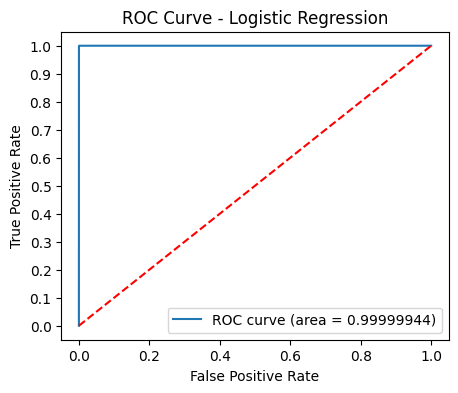

In [36]:
evaluate(lr_result,'Logistic Regression')

### Decision Tree

In [37]:
tree = DecisionTreeClassifier()
tree_pipeline = Pipeline(stages=[tree])
tree_model = tree_pipeline.fit(train)
tree_result = tree_model.transform(test)

Evaluate From Scratch:
+-----+----------+-------+
|label|prediction|  count|
+-----+----------+-------+
|    1|       0.0|     27|
|    0|       0.0|1717224|
|    1|       1.0|   6258|
|    0|       1.0|    106|
+-----+----------+-------+

EVALUATION SUMMARY for Decision Tree:
 accuracy:0.9999228365963396
 precision:0.9833438089252042
 recall:0.9957040572792363
 f1-score:0.9894853348090757

Evaluate From Spark Library:
Decision Tree Performance Measure
 Accuracy = 0.99992284
 Weighted Precision = 0.99992360
 Weighted Recall = 0.99992284
 F1 = 0.99992308
 Weighted F Measure = 0.99992308
 AUC = 0.99940730
 ROC curve:


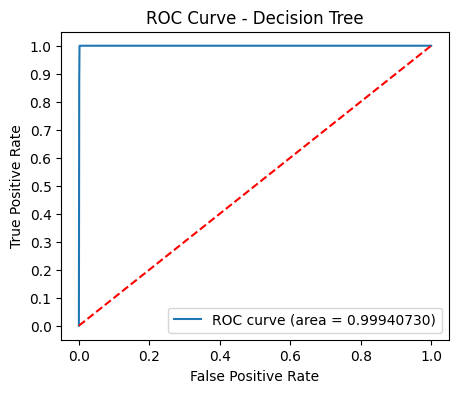

In [38]:
evaluate(tree_result,model_name='Decision Tree')

### RandomForest

In [32]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features")
rf_pipeline = Pipeline(stages=[ rf])
rf_model=rf_pipeline.fit(train)
rf_result=rf_model.transform(test)

Evaluate From Scratch:
+-----+----------+-------+
|label|prediction|  count|
+-----+----------+-------+
|    1|       0.0|    304|
|    0|       0.0|1717329|
|    1|       1.0|   5981|
|    0|       1.0|      1|
+-----+----------+-------+

EVALUATION SUMMARY for Random Forest:
 accuracy:0.9998230463299519
 precision:0.9998328318288198
 recall:0.9516308671439936
 f1-score:0.975136545202576

Evaluate From Spark Library:
Random Forest Performance Measure
 Accuracy = 0.99982305
 Weighted Precision = 0.99982305
 Weighted Recall = 0.99982305
 F1 = 0.99982087
 Weighted F Measure = 0.99982087
 AUC = 0.99996344
 ROC curve:


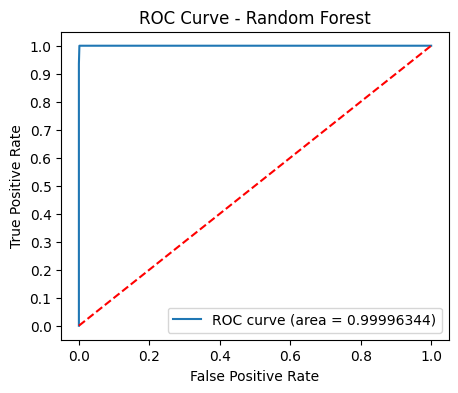

In [33]:
evaluate(rf_result,model_name='Random Forest')

In [33]:
from pyspark.ml.classification import LinearSVC
svc = LinearSVC(labelCol="label", featuresCol="features")
svc_pipeline = Pipeline(stages=[ svc])
svc_model=svc_pipeline.fit(train)
svc_result=svc_model.transform(test)

In [70]:
evaluate(svc_result,
         model_name='SVC',
         rawPredictionCol='rawPrediction',
         require_auc=False)

Evaluate From Scratch:
+-----+----------+-------+
|label|prediction|  count|
+-----+----------+-------+
|    1|       0.0|    244|
|    0|       0.0|1717417|
|    1|       1.0|   5945|
|    0|       1.0|      9|
+-----+----------+-------+

EVALUATION SUMMARY for SVC:
 accuracy:0.9998532154802552
 precision:0.9984884111521666
 recall:0.9605752140895136
 f1-score:0.9791649510005764

Evaluate From Spark Library:
rawPrediction
SVC Performance Measure
 Accuracy = 0.99985322
 Weighted Precision = 0.99985303
 Weighted Recall = 0.99985322
 F1 = 0.99985180
 Weighted F Measure = 0.99985180


In [ ]:
labels = ['Precision', 'Recall', 'Accuracy', 'ROC', 'Weighted F1']
models = ['LR', 'DT', 'RF', 'LinearSVC',]
arr = [
    [0.85,  0.74, 0.82, 0.88, 0.66],
    [0.87, 0.76, 0.83, 0.91, 0.67],
    [0.88, 0.75, 0.82, 0.91, 0.65],
    [0.87, 0.77, 0.84, 0.92, 0.69],
    [0.86, 0.77, 0.84, 0.92, 0.69],
    [0.88, 0.72, 0.79, 0.89, 0.61],
    [0.93, 0.73, 0.79, 0.91, 0.6],
]

x = np.arange(len(labels))
width = 0.125 

bars = []
for i in range(7):
    bars.append(plt.bar(x + (width * i), arr[i], width, label=models[i]))

plt.xlabel("Models")
plt.ylabel('Scores')
plt.title("Model Scores for class 1")
plt.xticks(x + 3 * width, labels)
plt.legend(loc=3)
plt.tight_layout()

plt.show()